In [96]:
import pandas as pd
import numpy as np
import tqdm
import json
import matplotlib.pyplot as plt

tqdm.tqdm.pandas()
plt.style.use("ggplot")

In [97]:
df = pd.read_json("./data/preprocessed/preprocessed.json", orient="index")
with open("./data/preprocessed/param.json", "r") as f:
    params = json.load(f)

In [98]:
df.head()

,valid_train_purchased_items,valid_eval_purchased_items,test_train_purchased_items,test_eval_purchased_items,valid_train_recommended_items,test_train_recommended_items
0,"[0, 1538, 515, 1029, 525, 1038, 1554, 1044, 53...","[740, 106, 657, 755, 986, 635]","[0, 1538, 515, 1029, 525, 1038, 1554, 1044, 53...","[899, 261, 139, 1419, 657, 1426, 1428, 533, 79...","[1, 2, 3, 4, 5, 6, 8, 10, 11, 14, 16, 17, 20, ...","[1, 2, 3, 4, 5, 6, 8, 10, 11, 14, 16, 17, 20, ..."
1,"[11, 14, 24, 25, 29, 31, 36, 37, 41, 43, 61, 6...","[1664, 261, 1419, 782, 1550, 1038, 785, 1554, ...","[11, 14, 24, 25, 29, 31, 36, 37, 41, 43, 61, 6...","[520, 20, 1044, 24, 28, 1054, 542, 36, 562, 10...","[0, 1, 2, 3, 4, 6, 7, 10, 11, 13, 14, 16, 17, ...","[0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 13, 14, 16, 1..."
2,"[1538, 4, 1541, 389, 1543, 1160, 1292, 1421, 9...","[834, 612, 1541, 842, 1421, 1136, 849, 912, 15...","[1538, 4, 1541, 389, 1543, 1160, 1292, 1421, 9...","[576, 834, 612, 1541, 614, 325, 877, 912, 1136...","[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15, 16, ...","[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 1..."
3,"[0, 3, 517, 5, 1035, 15, 1047, 1050, 1063, 107...","[769, 4, 1425, 790, 1431, 1195, 1078, 1208, 19...","[0, 3, 4, 517, 5, 1035, 15, 1047, 1050, 1063, ...","[1152, 128, 1416, 268, 1425, 1426, 1183, 1317,...","[0, 1, 2, 3, 6, 7, 13, 14, 16, 17, 18, 20, 21,...","[0, 1, 2, 3, 6, 7, 13, 14, 16, 17, 18, 20, 21,..."
4,"[640, 771, 4, 774, 646, 9, 783, 657, 1042, 142...","[832, 834, 771, 1060, 1125, 710, 966, 840, 157...","[4, 9, 1550, 1042, 1564, 1570, 1060, 1573, 157...",None,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 14, 16, 17, 19, 2...","[0, 1, 2, 3, 4, 6, 7, 9, 10, 14, 16, 17, 19, 2..."


In [99]:
params

{'user_n': 452, 'item_n': 1669}

In [100]:
MODE = "valid"
SEED = 0
ALPHA = 0.6
GAMMA_P = 0.2
GAMMA_R = 0.5
ETA = 1e-2
LAMBDA = 1e-6
D = 100
BATCH_SIZE = 1

USER_N = params["user_n"]
ITEM_N = params["item_n"]

print(f"user_n = {USER_N}, item_n = {ITEM_N}")

user_n = 452, item_n = 1669


In [101]:
rnd = np.random.RandomState(SEED)

X_u = rnd.normal(size=(USER_N, D))
X_v = rnd.normal(size=(ITEM_N, D))

EPS = 1e-4

In [102]:
df_dict = df.to_dict(orient="index")

In [103]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [107]:
losses = []

EPOCHS = 1_000_000
STEP_SIZE = 1_000


def sample_rmf() -> tuple[int, int, int]:
    C_P = 0
    C_NP = 1
    u = rnd.randint(0, USER_N)
    C = rnd.choice([C_P, C_NP], p=[GAMMA_P, 1 - GAMMA_P])

    if C == C_P:
        r_ui = 1
        i = rnd.choice(df_dict[u][f"{MODE}_train_purchased_items"])
    else:
        r_ui = 0
        while True:
            i = rnd.randint(0, ITEM_N)
            if i not in df_dict[u][f"{MODE}_train_purchased_items"]:
                break

    return u, i, r_ui


def sample_ulrmf() -> tuple[int, int, int]:
    C_RP = 0
    C_NR_NP = 1
    C_other = 2
    p_C_RP = GAMMA_P * GAMMA_R
    p_C_NR_NP = (1 - GAMMA_P) * (1 - GAMMA_R)
    p_C_other = 1 - p_C_RP - p_C_NR_NP

    u = rnd.randint(0, USER_N)
    C = rnd.choice([C_RP, C_NR_NP, C_other], p=[p_C_RP, p_C_NR_NP, p_C_other])

    if C == C_RP:
        r_ui = 1

        while True:
            i = rnd.choice(df_dict[u][f"{MODE}_train_purchased_items"])
            if i in df_dict[u][f"{MODE}_train_recommended_items"]:
                break
    elif C == C_NR_NP:
        if rnd.random() <= ALPHA:
            r_ui = 1
        else:
            r_ui = 0

        while True:
            i = rnd.randint(0, ITEM_N)
            if (
                i in df_dict[u][f"{MODE}_train_purchased_items"]
                and i not in df_dict[u][f"{MODE}_train_recommended_items"]
            ) or (
                i not in df_dict[u][f"{MODE}_train_purchased_items"]
                and i in df_dict[u][f"{MODE}_train_recommended_items"]
            ):
                break
    else:
        r_ui = 0

        while True:
            i = rnd.randint(0, ITEM_N)
            if (
                i not in df_dict[u][f"{MODE}_train_purchased_items"]
                and i not in df_dict[u][f"{MODE}_train_recommended_items"]
            ):
                break

    return u, i, r_ui


for t in range(EPOCHS):
    u, i, r_ui = sample_rmf()
    x_ui = sigmoid(np.dot(X_u[u], X_v[i]))

    X_u[u] -= ETA * (x_ui - r_ui) * X_v[i] + 2 * LAMBDA * X_u[u]
    X_v[i] -= ETA * (x_ui - r_ui) * X_u[u] + 2 * LAMBDA * X_v[i]

    L = -(r_ui * np.log(max(EPS, x_ui)) + (1 - r_ui) * np.log(max(EPS, 1 - x_ui)))

    if (t + 1) % STEP_SIZE == 0:
        print(
            f"[{t+1:8}/{EPOCHS}] {sum(losses[-STEP_SIZE:]) / STEP_SIZE:.8}",
            end="\r",
        )
    losses.append(L)

# np.save("./model/X_u.npy", X_u)
# np.save("./model/X_v.npy", X_v)

Text(0, 0.5, 'loss')

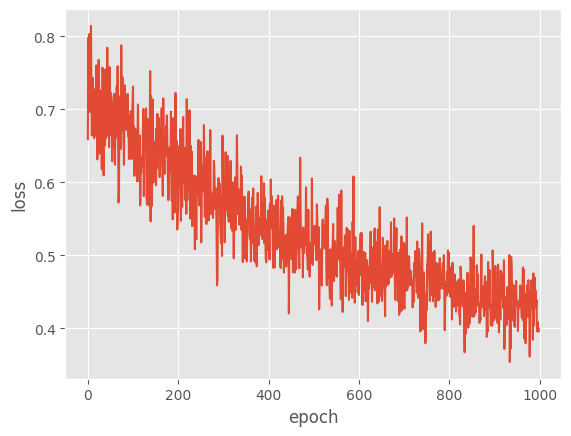

In [108]:
plt.plot([sum(losses[i : i + STEP_SIZE]) / STEP_SIZE for i in range(STEP_SIZE, EPOCHS, STEP_SIZE)])
plt.xlabel("epoch")
plt.ylabel("loss")

In [109]:
K = 30
acc = 0

for u in range(USER_N):
    if df_dict[u]["valid_eval_purchased_items"] is None:
        continue
    v = len(set(np.matmul(X_u[u], X_v.T).argsort()[-K:]) & set(df_dict[u]["valid_eval_purchased_items"]))
    acc += v

print(f"Accuracy = {acc / USER_N / K}")

Accuracy = 0.075


$$
-(r_{ui} \log \sigma (\hat{x}_{ui}) + (1 - r_{ui}) \log (1 - \sigma (\hat{x}_{ui})))
$$